**Ariel Yogev 207917501 & 
Guy Ben Moshe 318363397**

[Guy_Kaggle](https://www.kaggle.com/guybenmoshe)

**About**
> The Titanic is one of the most influential events in our culture, and therefore, there is great need and interest in researching this event. When the Titanic sank in 1912, the chances of survival were low. There were not enough life vests, and additionally, we discovered that there is a connection between sevra things to the chance to servive. For example, we found that gender influenced the chances of survival. In this notebook, we used passenger data, analyzed it, reached interesting conclusions, and finally trained models to achieve a high level of accuracy.

In [239]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re

import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import SGDClassifier


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [335]:
import plotly.io as pio
pio.renderers.default ='notebook'

In [240]:
titanic_train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
titanic_train_df.reset_index(drop=True, inplace=True)
display(titanic_train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


This is the full features table before changes and filling. We can see that there is irrelevant features like full name or Passenger Id.

In [241]:
titanic_train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

We can see that more people not survived in the titanic than survived.

In [242]:
titanic_train_df_cpy = titanic_train_df.copy()
pd.set_option('future.no_silent_downcasting', True)

#take only the status from the name
def extract_status(Name):
    match = re.search(r',\s*([^\.]*\.)', Name)
    if match:
        return match.group(1)
    return None

titanic_train_df_cpy['Status'] = titanic_train_df_cpy['Name'].apply(extract_status)

feature_to_drop = ['Ticket', 'Cabin', 'PassengerId', 'Name']
titanic_train_df_cpy = titanic_train_df_cpy.drop(feature_to_drop, axis=1)

titanic_train_df_cpy['Sex'] = titanic_train_df_cpy['Sex'].replace({'female': 0, 'male': 1})
titanic_train_df_cpy['Embarked'] = titanic_train_df_cpy['Embarked'].replace({'S': 0, 'C': 1, 'Q' : 2})
titanic_train_df_cpy['Status'] = titanic_train_df_cpy['Status'].replace({'Master.': 0, 'Miss.' : 1,'Mlle.' : 1 , 'Ms.' : 2, 'Mrs.' : 3, 'Mme.' : 3, 'Mr.': 4,'Col.' : 5, 'Capt.' : 5, 'Major.': 5, 'Rev.' : 6, 'Dr.' : 6, 'Don.': 7, 'Dona.' : 7, 'Jonkheer.': 7, 'Sir.' : 8, 'Lady.' : 9, 'the Countess.' : 10})

display(titanic_train_df_cpy)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Status
0,0,3,1,22.0,1,0,7.2500,0,4
1,1,1,0,38.0,1,0,71.2833,1,3
2,1,3,0,26.0,0,0,7.9250,0,1
3,1,1,0,35.0,1,0,53.1000,0,3
4,0,3,1,35.0,0,0,8.0500,0,4
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0,6
887,1,1,0,19.0,0,0,30.0000,0,1
888,0,3,0,NaN,1,2,23.4500,0,1
889,1,1,1,26.0,0,0,30.0000,1,4


---Removed unrelevant features ('Ticket', 'Cabin', 'PassengerId', 'Name') ---

--- Extracted from the name the Status and grade it 1-10 ---


In [243]:
titanic_train_df_cpy.isna().sum()


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Status        0
dtype: int64

We can see that there is a missing Data in the 'Age'and 'Embarked features that we need to fill.

In [244]:
# fill empty values in the dataframe
def fill_na_median(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    df.fillna({column_name: df_not_null[column_name].median()}, inplace=True)


def fill_na_mean(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    df.fillna({column_name: df_not_null[column_name].mean()}, inplace=True)


def fill_na_random_pick_column_distribution(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    # use lambda func to choose randomly from
    df[column_name] = df[column_name].apply(lambda x: np.random.choice(df_not_null[column_name]) if pd.isnull(x) else x)


fill_na_mean(titanic_train_df_cpy, 'Age')
fill_na_random_pick_column_distribution(titanic_train_df_cpy, 'Embarked')
titanic_train_df_cpy['Age'] = titanic_train_df_cpy['Age'].round(1)
titanic_train_df_cpy['Fare'] = titanic_train_df_cpy['Fare'].round(2)
titanic_train_df_cpy

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Status
0,0,3,1,22.0,1,0,7.25,0,4
1,1,1,0,38.0,1,0,71.28,1,3
2,1,3,0,26.0,0,0,7.92,0,1
3,1,1,0,35.0,1,0,53.10,0,3
4,0,3,1,35.0,0,0,8.05,0,4
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.00,0,6
887,1,1,0,19.0,0,0,30.00,0,1
888,0,3,0,29.7,1,2,23.45,0,1
889,1,1,1,26.0,0,0,30.00,1,4


we filled all the missing values: 
'Age' - filled by mean.
'Embarked' - filled by random( we have only 2 missing values so it doesnt have alot of impact.

In [245]:
titanic_train_df_cpy.isna().any()

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
Status      False
dtype: bool

Now we can safetly work with this Data, there is no empty cells.

<Axes: xlabel='Pclass', ylabel='Age'>

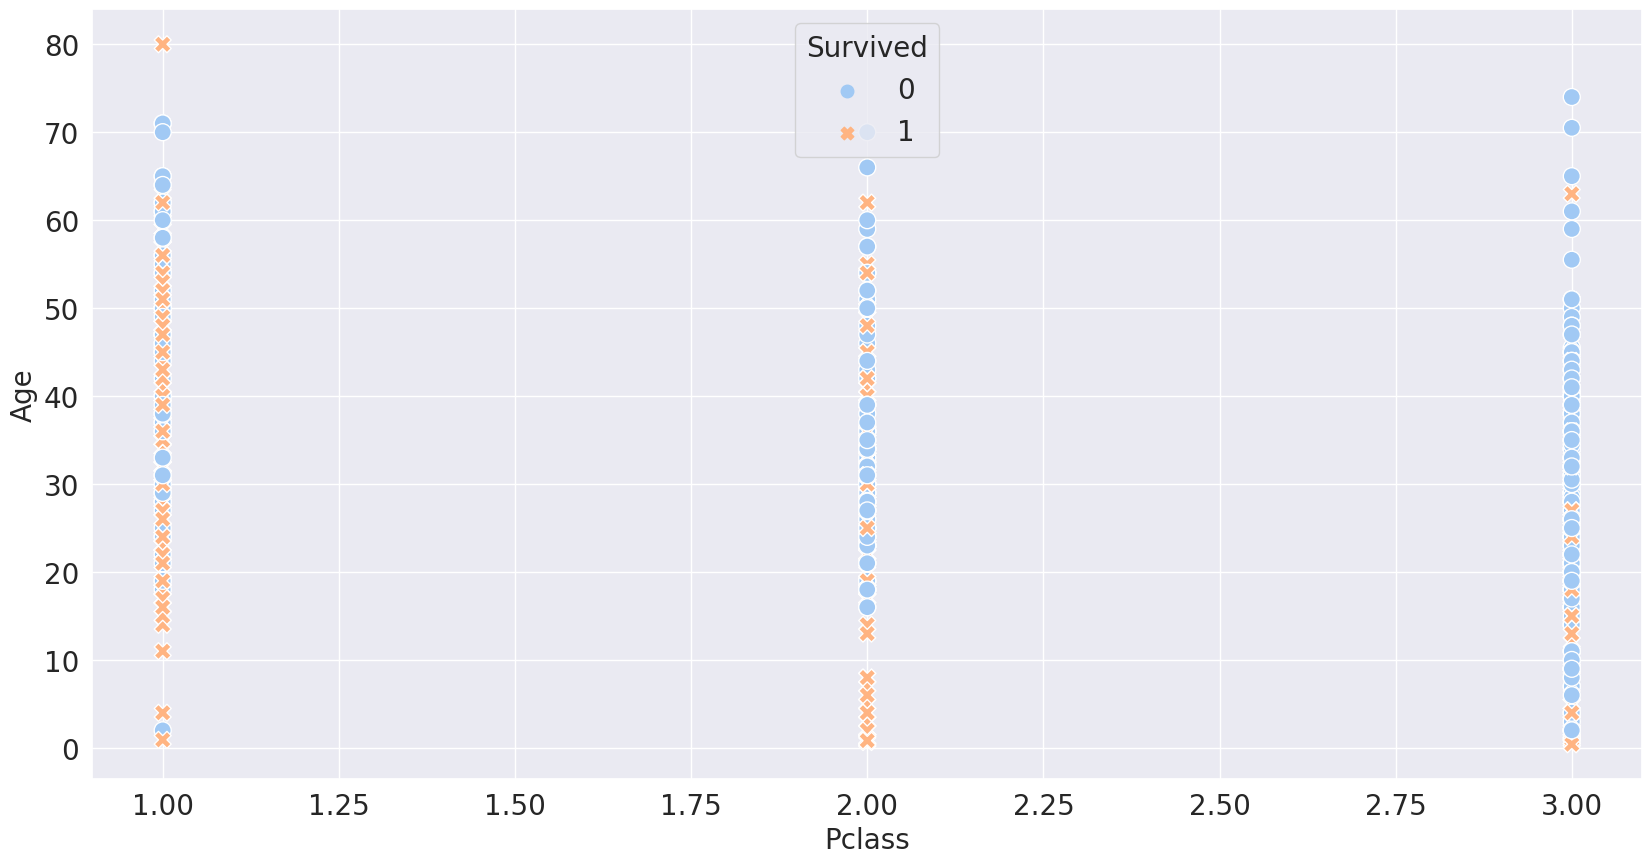

In [246]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=titanic_train_df, x="Pclass", y="Age", hue="Survived", style='Survived', palette='pastel', s=150)

In this graph we can see that people that have been in first class, had better chances to survive.

<Axes: xlabel='Sex', ylabel='Age'>

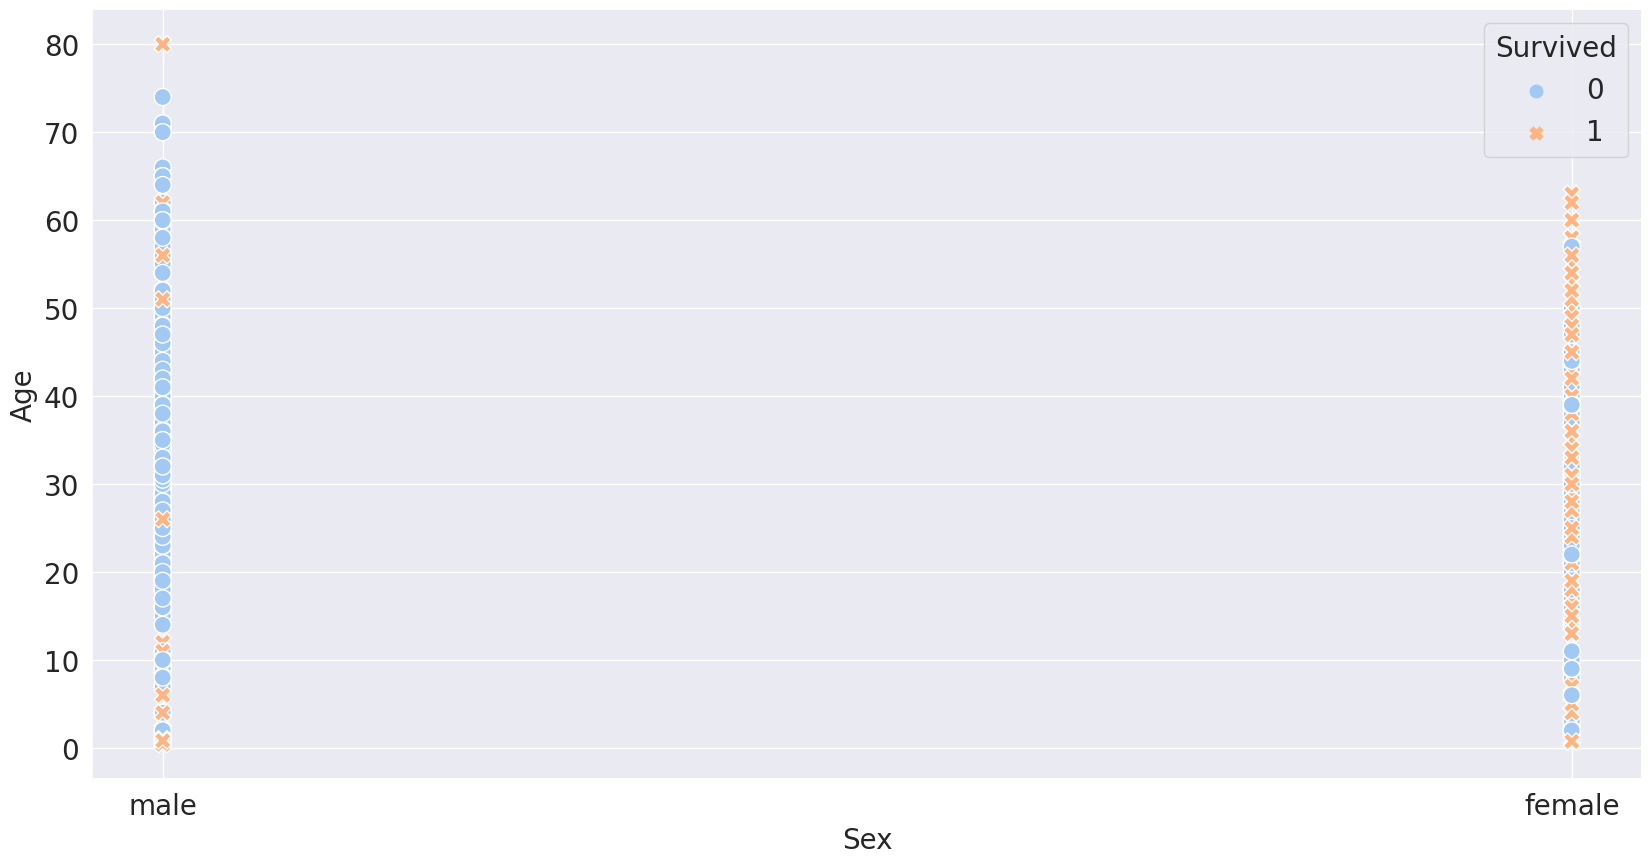

In [247]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=titanic_train_df, x="Sex", y="Age", hue="Survived", style='Survived', palette='pastel', s=150)

In this graph we can see that more old women survived than young women(0-15). on the other hand, more young mans survived than old one.
In general, more womens survived on the Titanic.

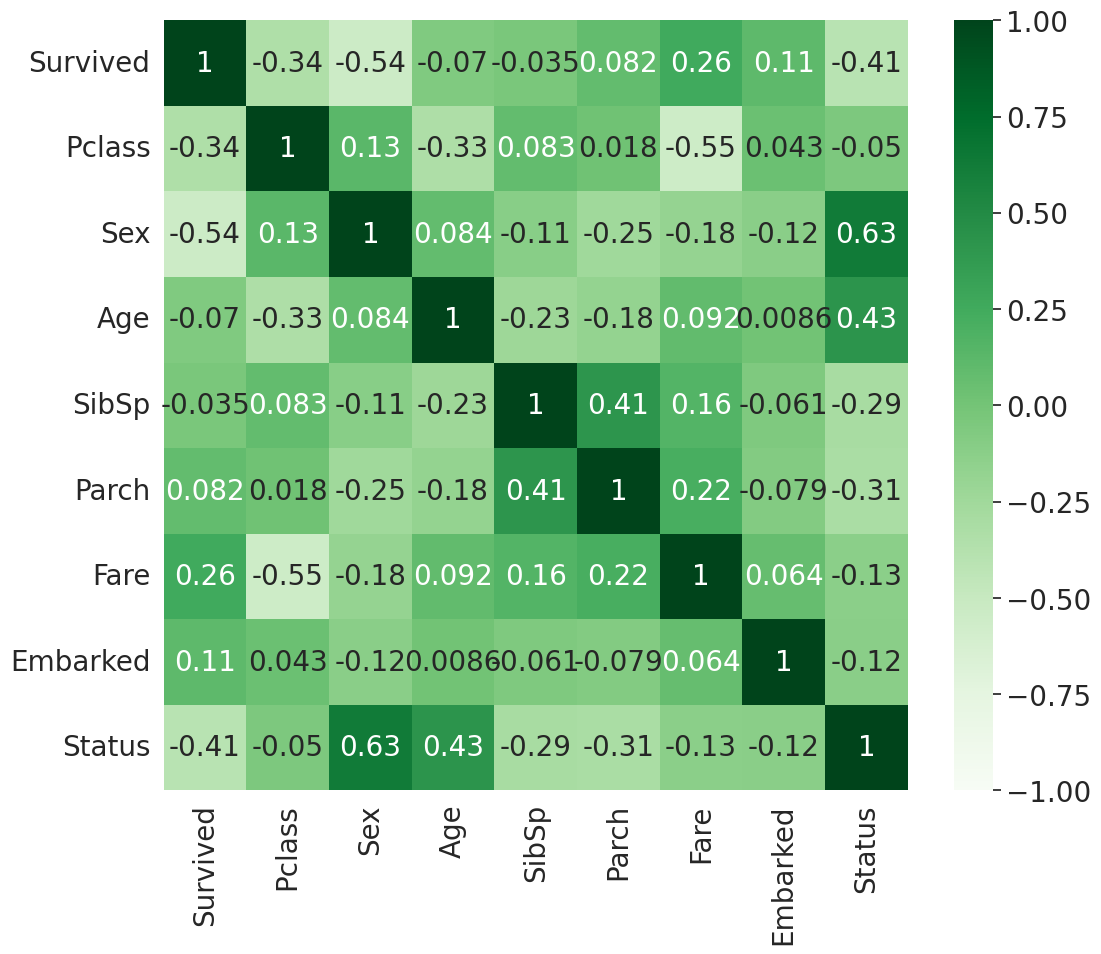

In [248]:
plt.figure(figsize=(12,10))
cor = titanic_train_df_cpy.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens, vmin=-1, vmax=1)
plt.show()

The survived feature has a high corellation with 'Status','Sex','Pclass'.
**We changed the 'Sex' Feature to Binary**

In [249]:
#make copy
titanic_train_df_cpy_2 = titanic_train_df_cpy.copy()
# add feature
titanic_train_df_cpy_2.insert(1, 'Status*Pclass', (titanic_train_df_cpy_2['Status']) * titanic_train_df_cpy_2['Pclass'])
# drop features
feature_to_drop = ['Parch', 'Embarked','Age', 'SibSp']
titanic_train_df_cpy_2 = titanic_train_df_cpy_2.drop(feature_to_drop, axis=1)



We added another copy for future comparing before and after features changing. Additionally, the classes feature split in a way that the better class is the lower number. so, for better results, we divided the class for the reverse ratio and dropped features that have low corellation with the survived feature.
We added the 'Status_Pclass' feature because we saw that both of the features have hige correlation with the 'Survived' feature.

In [250]:
titanic_train_df_cpy_2.isna().any()

Survived         False
Status*Pclass    False
Pclass           False
Sex              False
Fare             False
Status           False
dtype: bool

Making sure that there is no empty cells in our new features. Ready to work.

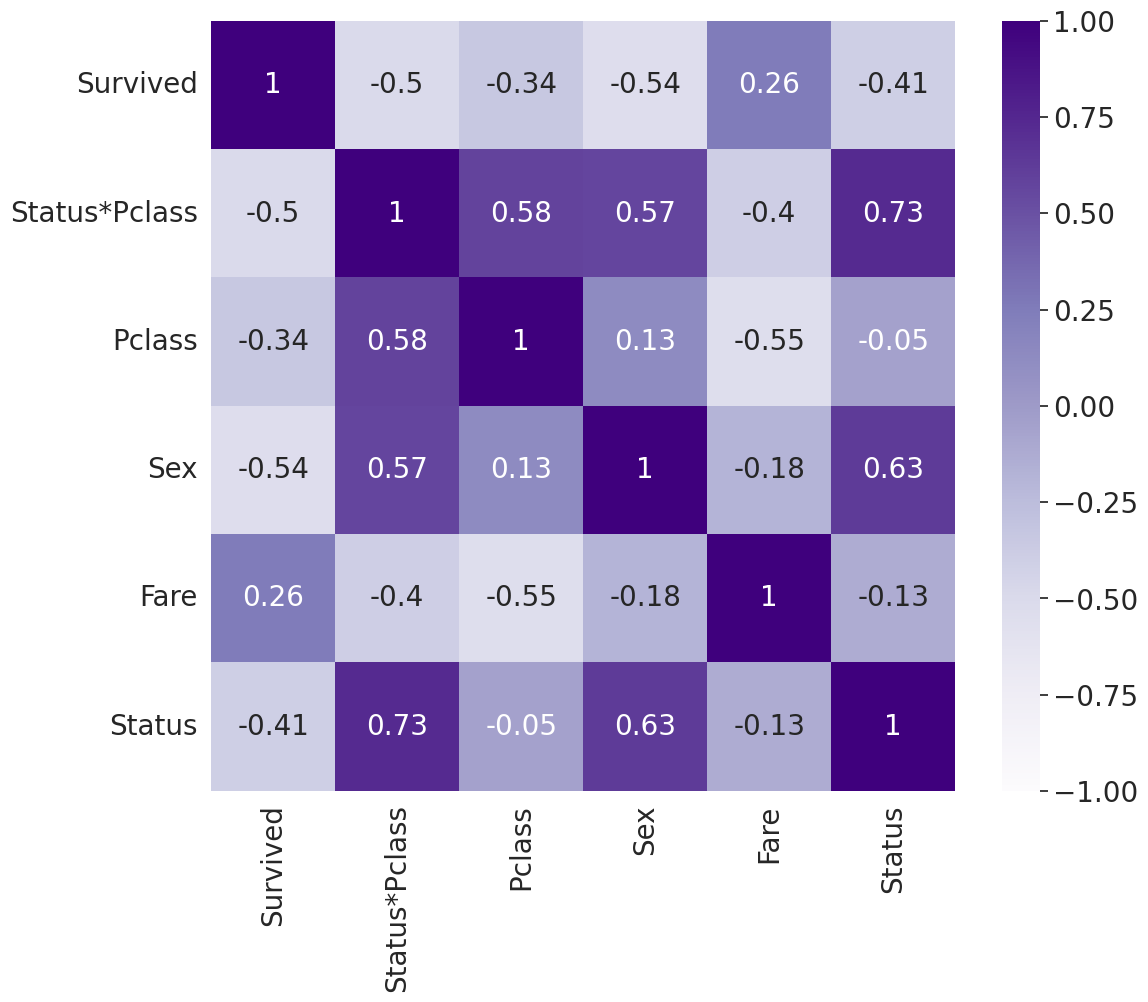

In [251]:
plt.figure(figsize=(12,10))
cor = titanic_train_df_cpy_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Purples,
            vmin=-1, vmax=1)
plt.show()

The survived feature has a high corellation with the new feature we created -'Status_Pclass' and 'Status'. the more you are in high sociaty's status and the more you have been in higher class, the more chances you survivrd the titanic. 

In [252]:
display(titanic_train_df_cpy_2)

,Survived,Status*Pclass,Pclass,Sex,Fare,Status
0,0,12,3,1,7.25,4
1,1,3,1,0,71.28,3
2,1,3,3,0,7.92,1
3,1,3,1,0,53.10,3
4,0,12,3,1,8.05,4
...,...,...,...,...,...,...
886,0,12,2,1,13.00,6
887,1,1,1,0,30.00,1
888,0,3,3,0,23.45,1
889,1,4,1,1,30.00,4


--- Final table ---

In [253]:
# print 4 graphs: ce of train/test and r2 of train/test
def print_graphs_r2_ce(graph_points):
    for k, v in graph_points.items():
        best_value = max(v.values()) if 'R2' in k else min(v.values())
        best_index = np.argmax(list(v.values())) if 'R2' in k else np.argmin(list(v.values()))
        color = 'r' if 'train' in k else 'b'
        plt.rcParams["figure.figsize"] = (16, 8)
        plt.plot(list(v.keys()), list(v.values()), color)
        plt.grid()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'{k}, best value: x={best_index + 1}, y={best_value}', fontsize=20)
        plt.show()

In [254]:
# plot the score by split and the loss by split for SGD
def plot_score_and_loss_by_split_SGD(x, t):
    graph_points = { 'train_CE': {}, 'val_CE': {}, 'train_R2': {}, 'val_R2': {} }

    for size in range(10, 100, 10):
        x_train, x_val, t_train, t_val = model_selection.train_test_split(x, t, test_size=size/100, random_state=42)
        SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train, t_train)
        y_train_prob = SGD_cls.predict_proba(x_train)
        y_test_prob = SGD_cls.predict_proba(x_val)
        y_train = SGD_cls.predict(x_train)
        y_val = SGD_cls.predict(x_val)
        graph_points['train_CE'][size/100] = metrics.log_loss(t_train, y_train_prob)
        graph_points['val_CE'][size/100] = metrics.log_loss(t_val, y_test_prob)
        graph_points['train_R2'][size/100] = SGD_cls.score(x_train, t_train)
        graph_points['val_R2'][size/100] = SGD_cls.score(x_val, t_val)
    print_graphs_r2_ce(graph_points)

t


0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


x


,Status*Pclass,Pclass,Sex,Fare,Status
0,12,3,1,7.25,4
1,3,1,0,71.28,3
2,3,3,0,7.92,1
3,3,1,0,53.10,3
4,12,3,1,8.05,4
...,...,...,...,...,...
886,12,2,1,13.00,6
887,1,1,0,30.00,1
888,3,3,0,23.45,1
889,4,1,1,30.00,4


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/skle

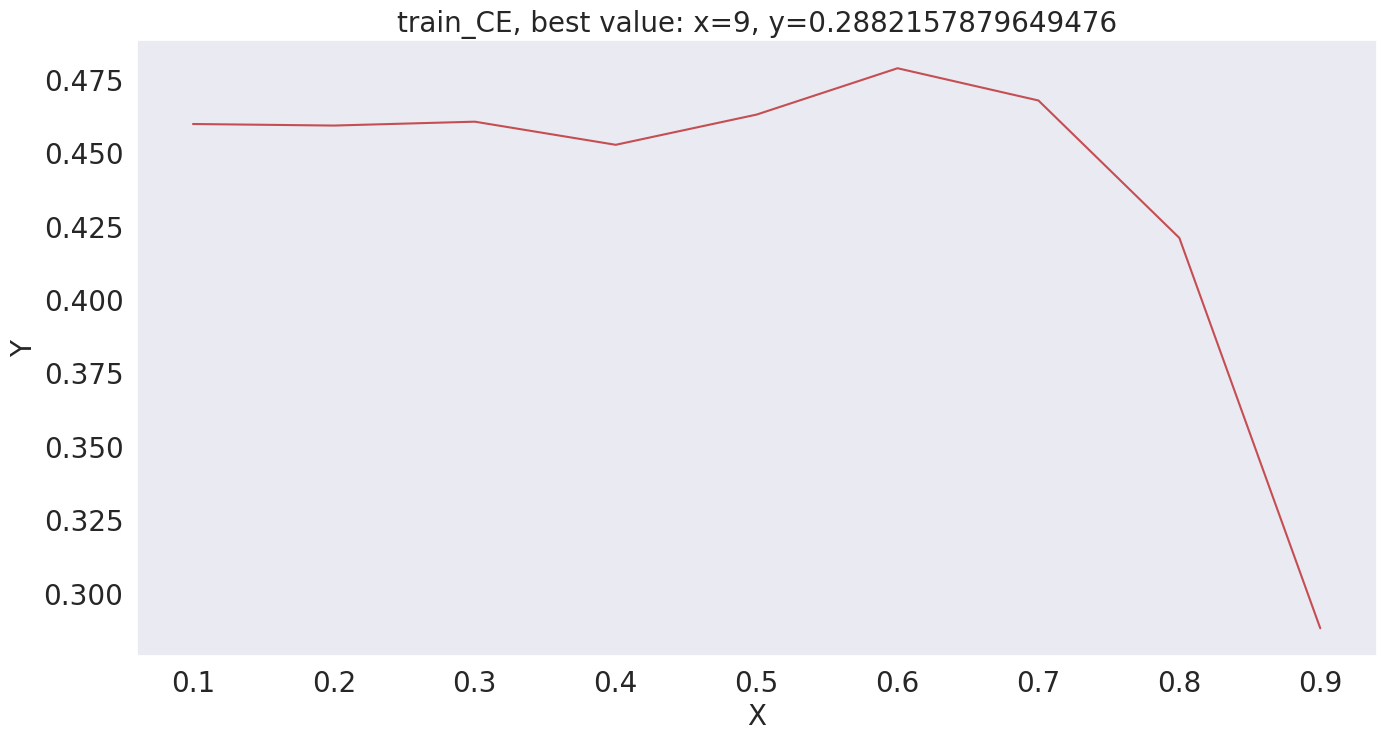

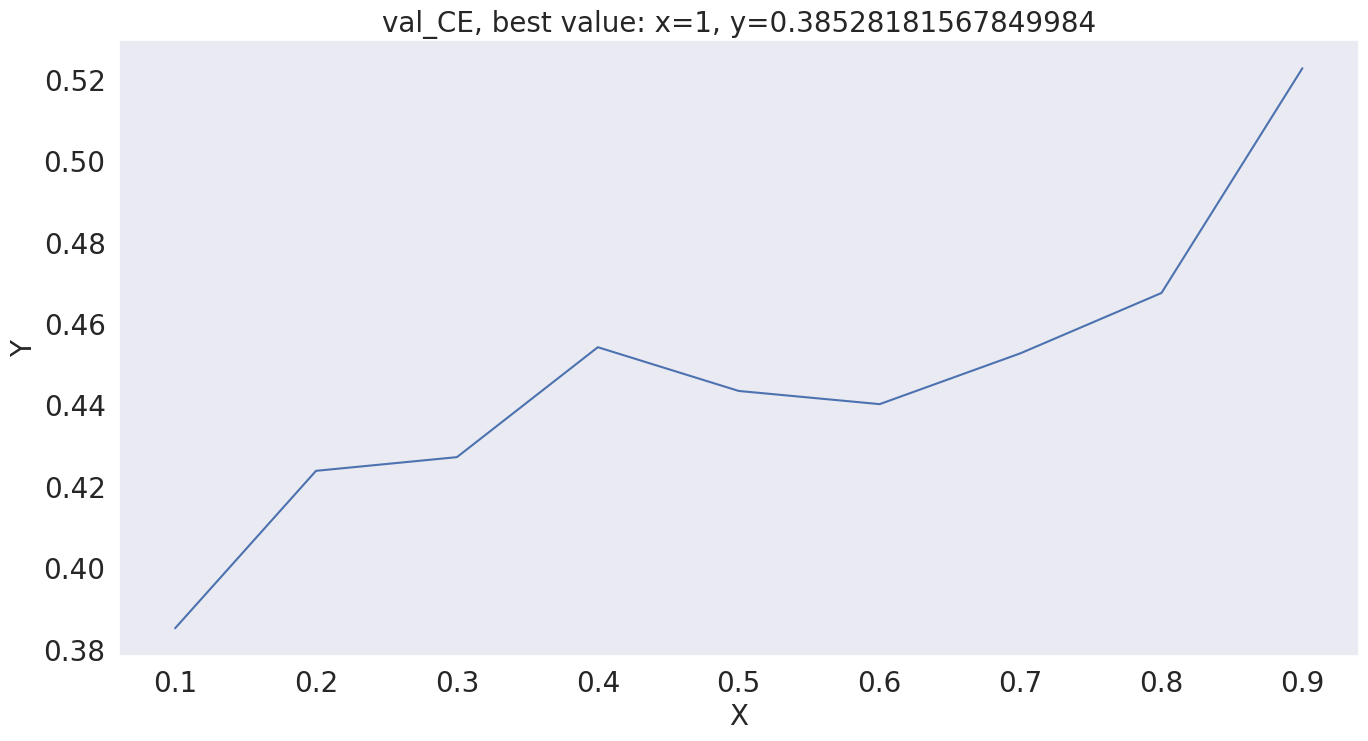

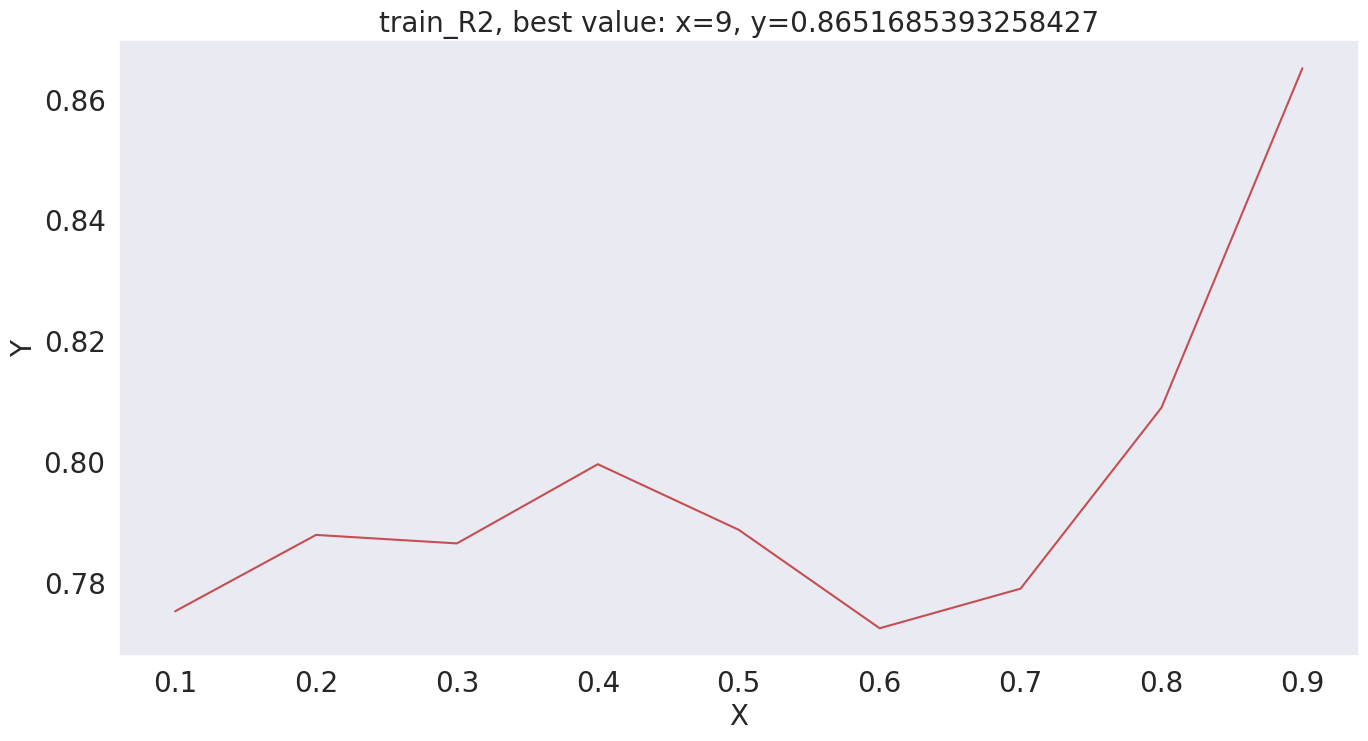

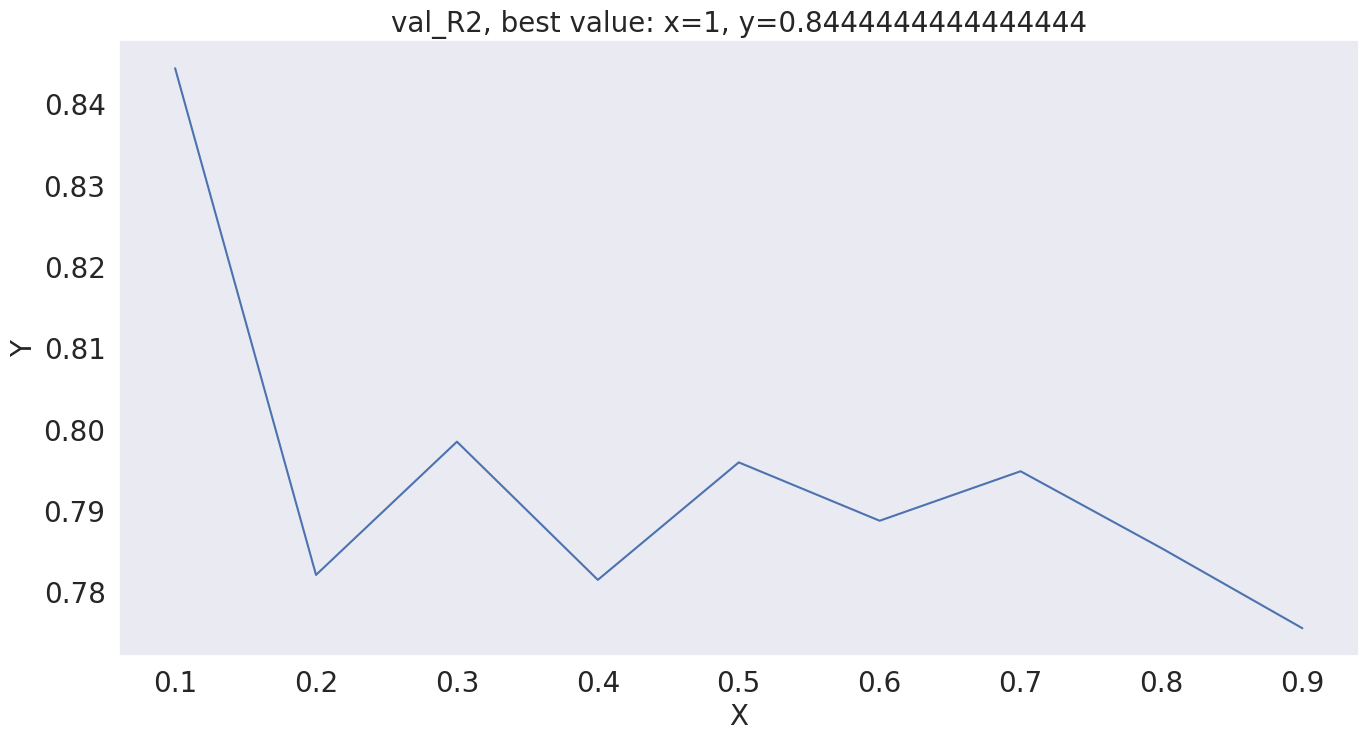

In [255]:
# divide the train data to features and target
t = titanic_train_df_cpy_2['Survived'].copy()
x = titanic_train_df_cpy_2.drop(['Survived'], axis=1)
print('t')
display(t)
print()
print('x')
display(x)

plot_score_and_loss_by_split_SGD(x,t)

In [256]:
t = titanic_train_df_cpy_2['Survived']
X = titanic_train_df_cpy_2.drop('Survived', axis=1)
X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(X, t, test_size=0.2, random_state=42)

In [257]:
# import neural_network and run MLP on the data
from sklearn import neural_network

MLP_cls = neural_network.MLPClassifier(
    activation='logistic',
     solver='sgd', alpha=0, max_iter=10000
     ).fit(X_train, t_train)

y_train_prob = MLP_cls.predict_proba(X_train)
y_test_prob = MLP_cls.predict_proba(X_test)

print('Accuracy score on train',
      MLP_cls.score(X_train, t_train))
print('Accuracy score on test',
      MLP_cls.score(X_test, t_test))
print()
print('CE on train',
      metrics.log_loss(t_train, y_train_prob))
print('CE on test',
      metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.7064606741573034
Accuracy score on test 0.7821229050279329

CE on train 0.5397361176770371
CE on test 0.47558572694080425


We checked the score with another model and the conclusion was that the SGD model is better fit for this type of data.

In [258]:
# create the SGDClassifier and predict the probabilities of the train and test data
SGD_cls = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
     linear_model.SGDClassifier(loss='log_loss', alpha=0,
                                learning_rate='constant',
                                eta0=0.01)
     ).fit(X_train, t_train)

# predict probabilities
y_train_prob = SGD_cls.predict_proba(X_train)
y_test_prob = SGD_cls.predict_proba(X_test)

# predicting test and train test results
y_train = SGD_cls.predict(X_train)
y_test = SGD_cls.predict(X_test)

print('first 5 probabilities of y_train_prob:')
print(y_train_prob[:5])
print()
print('first 5 predictions of y_train:')
print(y_train[:5])
print()
print('first 5 probabilities of y_test_prob:')
print(y_test_prob[:5])
print()
print('first 5 predictions of y_test:')
print(y_test[:5])

first 5 probabilities of y_train_prob:
[[0.5851603  0.4148397 ]
 [0.78453134 0.21546866]
 [0.90244471 0.09755529]
 [0.90245409 0.09754591]
 [0.38404698 0.61595302]]

first 5 predictions of y_train:
[0 0 0 0 1]

first 5 probabilities of y_test_prob:
[[0.81618027 0.18381973]
 [0.78517389 0.21482611]
 [0.90244471 0.09755529]
 [0.16453671 0.83546329]
 [0.39128762 0.60871238]]

first 5 predictions of y_test:
[0 0 0 1 1]


In [259]:
def compare_pred_prettify(y_test_prob,t_test,y_test, class_A, class_B):
  # conver to float with 2-digit after zero
  y_test_prob = np.round(y_test_prob, 2)
  res = "{:<10} | {:<10} | {:<10} | {:<13}".format("t_test", "y_test", f"{class_A}(%)", f"{class_B}(%)\n")
  res += "-"*65+"\n"
  res += "\n".join("{:<10} | {:<10} | {:<10} | {:<13}".format(x, y, a, b) for x, y, a, b in zip(t_test, y_test, y_test_prob[:,0], y_test_prob[:,1]))
  res += "\n"+"-"*65+"\n"
  print(res)

compare_pred_prettify(y_test_prob,t_test,y_test,'Survived','Not Survived')

t_test     | y_test     | Survived(%) | Not Survived(%)
-----------------------------------------------------------------
1          | 0          | 0.82       | 0.18         
0          | 0          | 0.79       | 0.21         
0          | 0          | 0.9        | 0.1          
1          | 1          | 0.16       | 0.84         
1          | 1          | 0.39       | 0.61         
1          | 1          | 0.05       | 0.95         
1          | 1          | 0.39       | 0.61         
0          | 0          | 0.9        | 0.1          
1          | 1          | 0.39       | 0.61         
1          | 1          | 0.06       | 0.94         
0          | 0          | 0.58       | 0.42         
0          | 0          | 0.9        | 0.1          
0          | 1          | 0.39       | 0.61         
0          | 0          | 0.9        | 0.1          
0          | 0          | 0.78       | 0.22         
1          | 1          | 0.06       | 0.94         
1          | 0          | 0.58

In [260]:
# print the accuracy score and CE loss of the train and test
print('Accuracy score on train',SGD_cls.score(X_train, t_train))
print('Accuracy score on test',SGD_cls.score(X_test, t_test))
print()
print('CE on train',metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.7893258426966292
Accuracy score on test 0.7877094972067039

CE on train 0.4569576126894994
CE on test 0.42562623469248373


**Our score is 0.7921 for train**
Now we will try the model on test.

In [261]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df_cpy = test_df.copy()
test_df.reset_index(drop=True, inplace=True)
display(test_df)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [262]:

#take only the status from the name
def extract_status(Name):
    match = re.search(r',\s*([^\.]*\.)', Name)
    if match:
        return match.group(1)
    return None

test_df['Status'] = test_df['Name'].apply(extract_status)

feature_to_drop = ['Ticket', 'Cabin', 'PassengerId', 'Name','Age']
test_df = test_df.drop(feature_to_drop, axis=1)

test_df['Sex'] = test_df['Sex'].replace({'female': 0, 'male': 1})
test_df['Embarked'] = test_df['Embarked'].replace({'S': 0, 'C': 1, 'Q' : 2})
test_df['Status'] = test_df['Status'].replace({'Master.': 0, 'Miss.' : 1,'Mlle.' : 1 , 'Ms.' : 2, 'Mrs.' : 3, 'Mme.' : 3, 'Mr.': 4,'Col.' : 5, 'Capt.' : 5, 'Major.': 5, 'Rev.' : 6, 'Dr.' : 6, 'Don.': 7,'Dona.' : 7, 'Jonkheer.': 7, 'Sir.' : 8, 'Lady.' : 9, 'the Countess.' : 10})

display(test_df)

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Status
0,3,1,0,0,7.8292,2,4
1,3,0,1,0,7.0000,0,3
2,2,1,0,0,9.6875,2,4
3,3,1,0,0,8.6625,0,4
4,3,0,1,1,12.2875,0,3
...,...,...,...,...,...,...,...
413,3,1,0,0,8.0500,0,4
414,1,0,0,0,108.9000,1,7
415,3,1,0,0,7.2500,0,4
416,3,1,0,0,8.0500,0,4


In [263]:
# add feature
test_df.insert(0, 'Status*Pclass', (test_df['Status']) * test_df['Pclass'])
# drop features
feature_to_drop = ['Parch', 'Embarked', 'SibSp']
test_df = test_df.drop(feature_to_drop, axis=1)


In [264]:
test_df.isna().any()

Status*Pclass    False
Pclass           False
Sex              False
Fare              True
Status           False
dtype: bool

We can see that we need to fill the 'Fare' feature.

In [265]:
# fill empty values in the dataframe
def fill_na_median(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    df.fillna({column_name: df_not_null[column_name].median()}, inplace=True)


def fill_na_mean(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    df.fillna({column_name: df_not_null[column_name].mean()}, inplace=True)


def fill_na_random_pick_column_distribution(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    # use lambda func to choose randomly from
    df[column_name] = df[column_name].apply(lambda x: np.random.choice(df_not_null[column_name]) if pd.isnull(x) else x)



fill_na_mean(test_df, 'Fare')
test_df['Fare'] = test_df['Fare'].round(2)
test_df

,Status*Pclass,Pclass,Sex,Fare,Status
0,12,3,1,7.83,4
1,9,3,0,7.00,3
2,8,2,1,9.69,4
3,12,3,1,8.66,4
4,9,3,0,12.29,3
...,...,...,...,...,...
413,12,3,1,8.05,4
414,7,1,0,108.90,7
415,12,3,1,7.25,4
416,12,3,1,8.05,4


In [266]:
test_df.isna().any()

Status*Pclass    False
Pclass           False
Sex              False
Fare             False
Status           False
dtype: bool

After sucssefuly filling

In [267]:
test_prediction = SGD_cls.predict(test_df)

In [268]:
#create sumission file
submission = pd.DataFrame({
    'PassengerId': test_df_cpy['PassengerId'],
    'Survived': test_prediction
})
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


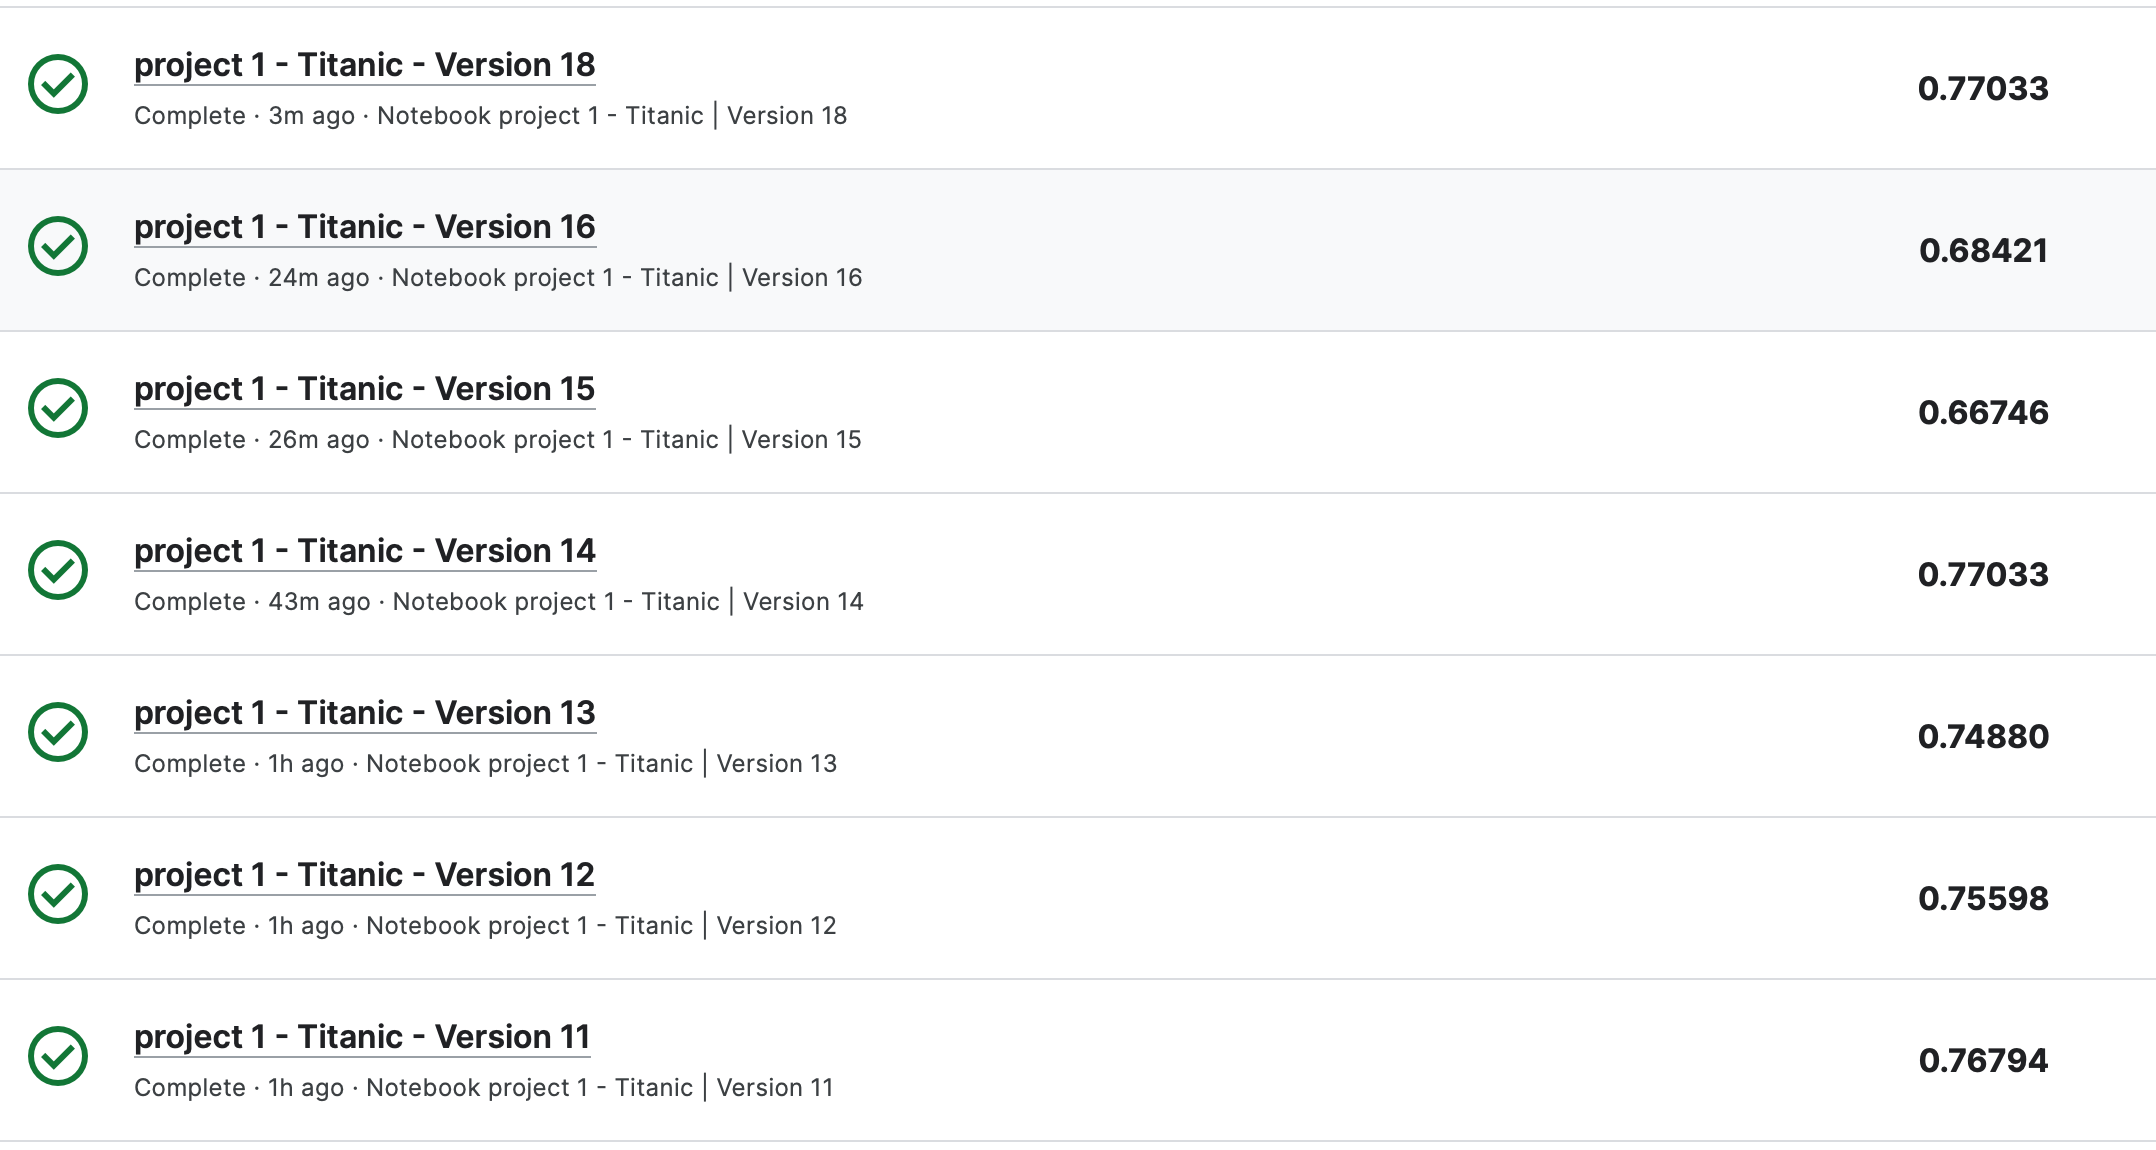

**BEST SCORE - 0.77033**

**Conclusions**
> After researching and analyzing the data, we performed several experiment on different models - SGDClassifier and MLP.
in each model we tried to create new features like 'Status' or combine of two like 'Status_Pclass' or to drop some irrelevant features like 'PassengerId' or features that we saw that doesn't have correlation with the 'Survive' feature.
Additionally, we changed in each experiment the data/validation division for testing what will be the best for our models.
We came to conclusion that the best data to use is the data with the 2 new features we created, with division of 20% train and 80% validation for the SGDClassifier model.

# **--- Exercise  3---**

In this exercise we will try to improve our score from exercise 1.

We are gonna use the K-Fold method,Hyper-Parameters Search- grid search and random search,
Ensembles- bagging and boosting and feature selection methods.

# Cross Validation

In [269]:
# find generator length
def find_generator_len(generator, use_pbar=True):
    i = 0
    
    if use_pbar:
        pbar = tqdm(desc='Calculating Length', ncols=1000, bar_format='{desc}{bar:10}{r_bar}')

    for a in generator:
        i += 1

        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    return i

In [270]:
# calculate precision, recall, specificity, fpr and accuracy
def precision(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fp)

def recall(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fn)

def specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    return tn/(tn+fp)

def fpr(cm):
    tn, fp, fn, tp = cm.ravel()
    return fp/(fp+tn)

def accuracy(cm):
    tn, fp, fn, tp = cm.ravel()
    return (tp+tn)/(tp+tn+fp+fn)

# calculate f1 and balanced accuracy
def f1(cm):
    precision_calc = precision(cm)
    recall_calc = recall(cm)
    return (2*precision_calc*recall_calc)/(precision_calc+recall_calc)

def balanced_accuracy(cm):
    recall_calc = recall(cm)
    specificity_calc = specificity(cm)
    return (recall_calc+specificity_calc)/2

def calc_metrics(cm):
    return{
      'precision': precision(cm),
      'recall': recall(cm),
      'specificity': specificity(cm),
      'fpr': fpr(cm),
      'accuracy': accuracy(cm),
      'f1': f1(cm),
      'balanced accuracy': balanced_accuracy(cm),
  }

In [271]:
# print all metrics from confusion_matrix for train and validation
def print_confusion_matrix(model, cm_train, cm_val):
    cm_train_df = pd.DataFrame(cm_train, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])
    cm_val_df = pd.DataFrame(cm_val, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

    print('Confusion Matrix')
    fig, ax = plt.subplots(ncols=2, figsize=(10,3))
    for i, (df, title) in enumerate(zip([cm_train_df, cm_val_df], ['Train', 'Validation'])):
        fig = sns.heatmap(df, annot=True, ax=ax[i], cmap=plt.cm.Pastel1, fmt='g')
        fig.set_title(title)
    plt.subplots_adjust(top=1.5, bottom=0, left=0, right=1)
    plt.show()

    display(pd.DataFrame({ 'Tarin': calc_metrics(cm_train), 'Validation': calc_metrics(cm_val) }))

In [272]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, LeavePOut
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def get_cv_score_and_loss(X, t, model, k=None, p=None, show_score_loss_graphs=False, use_pbar=True):
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
    elif p is not None:
        cv = LeavePOut(p)
    else:
        raise ValueError('You need to specify k or p for the CV to work.')

    if use_pbar:
        pbar = tqdm(desc='Computing Models', total=cv.get_n_splits(X))

    # Initialize lists to store metrics
    all_true_labels = []
    all_predictions = []

    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.iloc[train_ids]
        t_train = t.iloc[train_ids]
        X_val = X.iloc[val_ids]
        t_val = t.iloc[val_ids]

        model.fit(X_train, t_train)

        y_train = model.predict(X_train)
        y_val = model.predict(X_val)

        # Store metrics for each fold
        all_true_labels.extend(t_val)
        all_predictions.extend(y_val)

        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train), 1 - accuracy_score(t_train, y_train)]
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'val', model.score(X_val, t_val), 1 - accuracy_score(t_val, y_val)]

        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    # Compute confusion matrix
    conf_mat = confusion_matrix(all_true_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(12, 7))
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Greens')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    TN, FP, FN, TP = conf_mat.ravel()

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)

    # Calculate FPR and Specificity
    fpr = FP / (FP + TN)
    specificity = TN / (TN + FP)
    # Print KPIs
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')
    print(f'False Positive Rate (FPR): {fpr:.2f}')
    print(f'Specificity: {specificity:.2f}')

    val_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'train']

    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    if show_score_loss_graphs:
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))

        for split, group in scores_losses_df.groupby('split'):
            if split == 'train':
                color = 'blue'
            else:
                color = 'green'
            axs[0].plot(group['fold_id'], group['score'], label=f'{split} score', color=color)
            axs[1].plot(group['fold_id'], group['loss'], label=f'{split} loss', color=color)

        axs[0].set_title(f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        axs[0].set_xlabel('Fold ID')
        axs[0].set_ylabel('Score')
        axs[0].legend()

        axs[1].set_title(f'Mean Val Loss: {mean_val_loss:.2f}, Mean Train Loss: {mean_train_loss:.2f}')
        axs[1].set_xlabel('Fold ID')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss


# KNN, grid search

In [273]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create the scaler
scaler = StandardScaler()

all_cols = np.array(X.columns)
## FOR ENSEMBLE All the other ways we will use pipe
X_encoded = pd.DataFrame(scaler.fit_transform(x), columns=all_cols)

# Define the pipeline steps
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the hyperparameters for grid search
hyper_parameters = {'knn__n_neighbors': list(range(1, 20))}

# Create the GridSearchCV object
gs_neigh_model = GridSearchCV(pipe, hyper_parameters, cv=5).fit(X_encoded, t)

# Output the results
print('Accuracy score for classification:')
print('Best score:', gs_neigh_model.best_score_)
print('Best params:', gs_neigh_model.best_params_)

Accuracy score for classification:
Best score: 0.8114744837110036
Best params: {'knn__n_neighbors': 8}


Computing Models: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


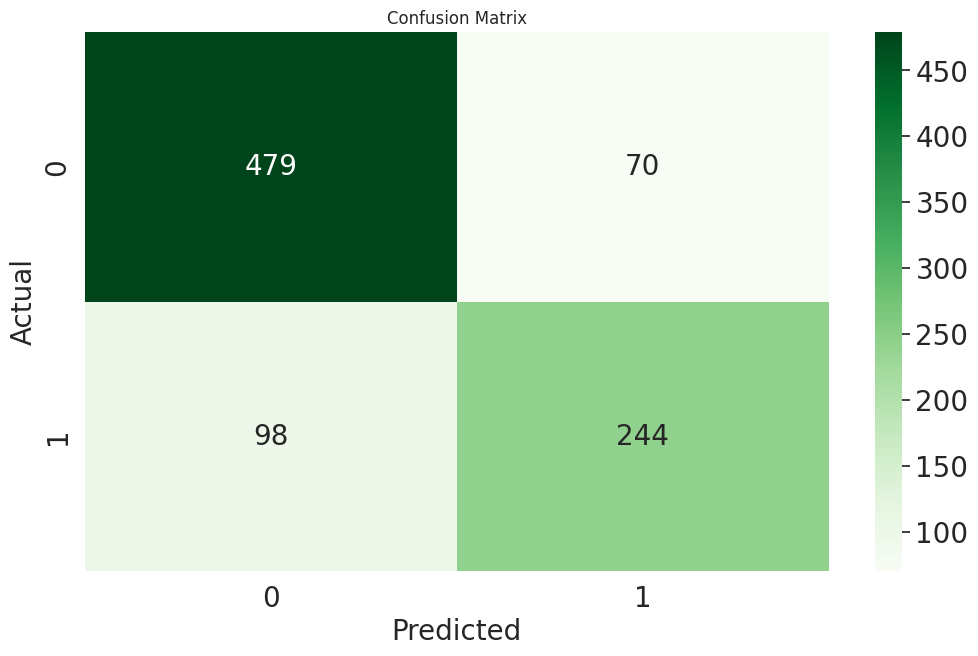

Precision: 0.78
Recall: 0.71
F1-score: 0.74
False Positive Rate (FPR): 0.13
Specificity: 0.87


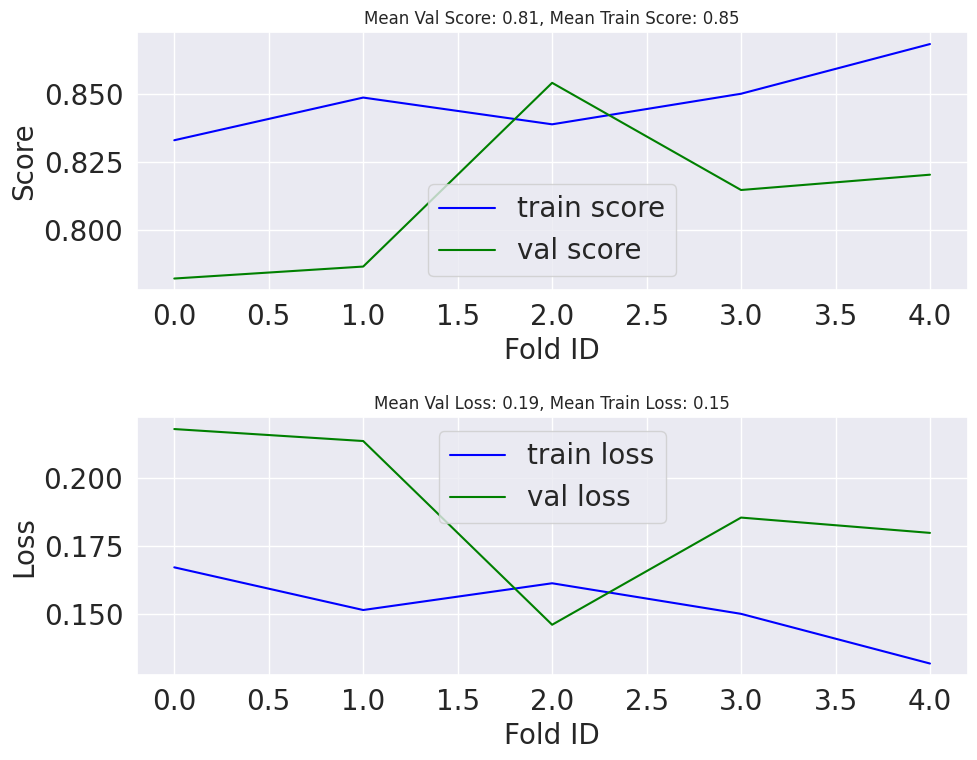

mean cv val score: 0.81
mean cv val loss 0.19
mean cv val score: 0.85
mean cv val loss 0.15


In [274]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_encoded, t, gs_neigh_model, k=5, p=None, show_score_loss_graphs=True, use_pbar=True)
print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
print(f'mean cv val score: {train_score:.2f}\nmean cv val loss {train_loss:.2f}')

# Feature Selection

In [275]:
from sklearn.feature_selection import SequentialFeatureSelector
knn_model = KNeighborsClassifier(n_neighbors=8)

feature_selector = SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=5),
                                             n_features_to_select=4,
                                             direction='forward')
# Create a pipeline with feature selection and KNN
pipe = Pipeline([
    ('feature_selection', feature_selector),
    ('knn', knn_model)
])

# Fit the pipeline on the training data
pipe.fit(x,t)

# # Get selected features (if needed)
# selected_features_forward = train_data[:, feature_selector.get_support()]

# Get boolean mask of selected features
selected_features_mask = feature_selector.get_support()

# Print selected features
selected_features_indices = np.where(selected_features_mask)[0]
print(f"Selected Features Indices: {selected_features_indices}")

# Optionally, transform X_train to get selected features
X_train_selected = X.loc[:,selected_features_mask]
X_train_selected

Selected Features Indices: [0 1 2 4]


,Status*Pclass,Pclass,Sex,Status
0,12,3,1,4
1,3,1,0,3
2,3,3,0,1
3,3,1,0,3
4,12,3,1,4
...,...,...,...,...
886,12,2,1,6
887,1,1,0,1
888,3,3,0,1
889,4,1,1,4


In [276]:
# Forward Selection
sfs_forward = SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=5),
                                        n_features_to_select=4,
                                        direction='forward')
sfs_forward.fit(x, t)

selected_features_forward = X.columns[sfs_forward.get_support()]
print("Forward Selection: ", selected_features_forward)

# Backward Selection
sfs_backward = SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=5),
                                         n_features_to_select=4,
                                         direction='backward')
sfs_backward.fit(x, t)

selected_features_backward = X.columns[sfs_backward.get_support()]
print("Backward Selection: ", selected_features_backward)


Forward Selection:  Index(['Status*Pclass', 'Pclass', 'Sex', 'Status'], dtype='object')
Backward Selection:  Index(['Status*Pclass', 'Pclass', 'Sex', 'Status'], dtype='object')


same features for forward and backward

In [277]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=8))
])

Computing Models: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


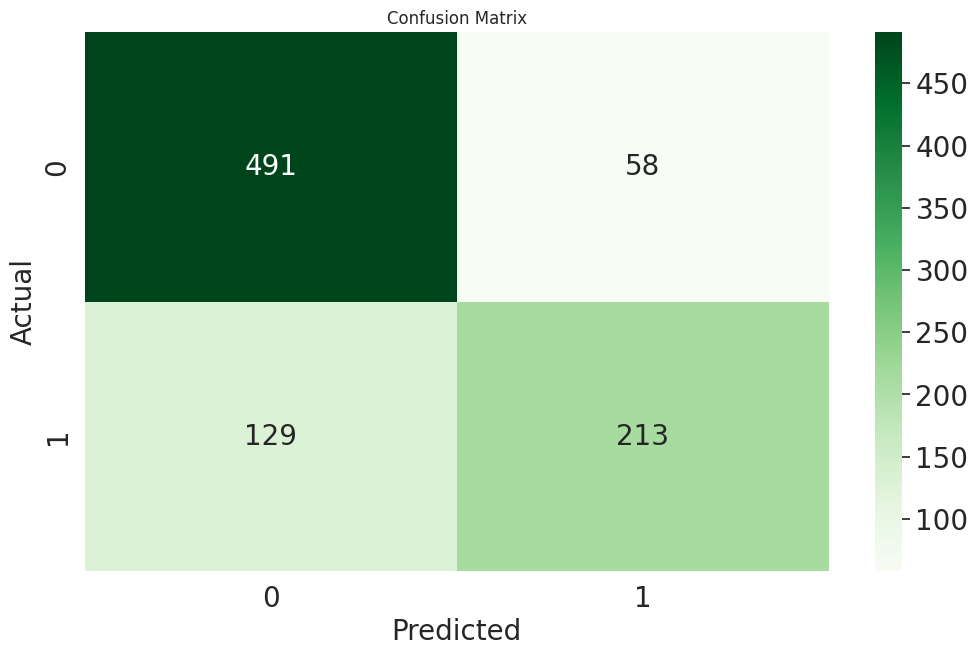

Precision: 0.79
Recall: 0.62
F1-score: 0.69
False Positive Rate (FPR): 0.11
Specificity: 0.89


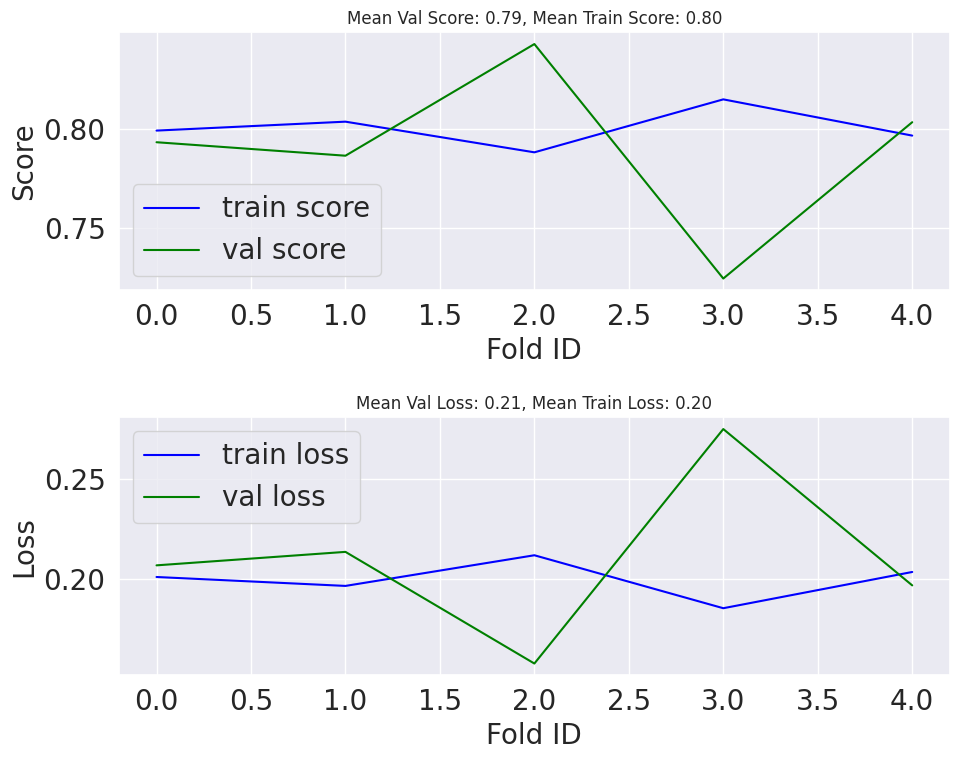

mean cv val score: 0.79
mean cv val loss 0.21
mean cv val score: 0.80
mean cv val loss 0.20


In [278]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(x[selected_features_forward], t, pipeline, k=5, p=None, show_score_loss_graphs=True, use_pbar=True)
print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
print(f'mean cv val score: {train_score:.2f}\nmean cv val loss {train_loss:.2f}')

# Ensembles

Bagging

In [279]:
all_cols

array(['Status*Pclass', 'Pclass', 'Sex', 'Fare', 'Status'], dtype=object)

In [323]:
# get score with nfold bagging
from sklearn.ensemble import BaggingClassifier

X_encoded = pd.DataFrame(scaler.fit_transform(X), columns=all_cols)

bag_fold_model = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=16),
                                   n_estimators=20, random_state=42,
                                   bootstrap=False).fit(X_encoded, t)

print('Accuracy score for classification:')
print('bag_fold_model', bag_fold_model.score(X_encoded, t).mean())

Accuracy score for classification:
bag_fold_model 0.835016835016835


Computing Models: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


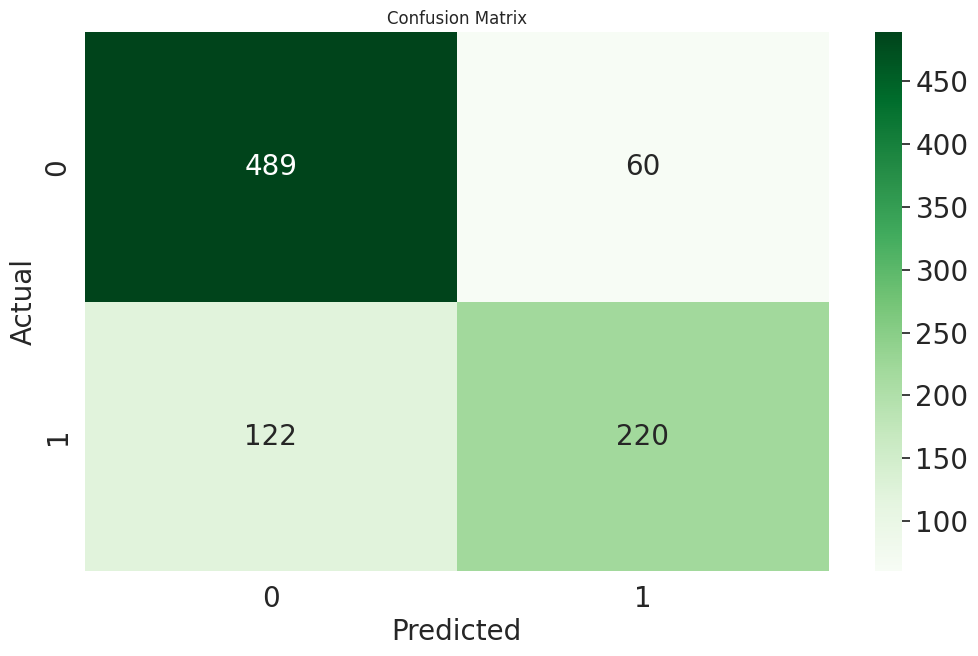

Precision: 0.79
Recall: 0.64
F1-score: 0.71
False Positive Rate (FPR): 0.11
Specificity: 0.89


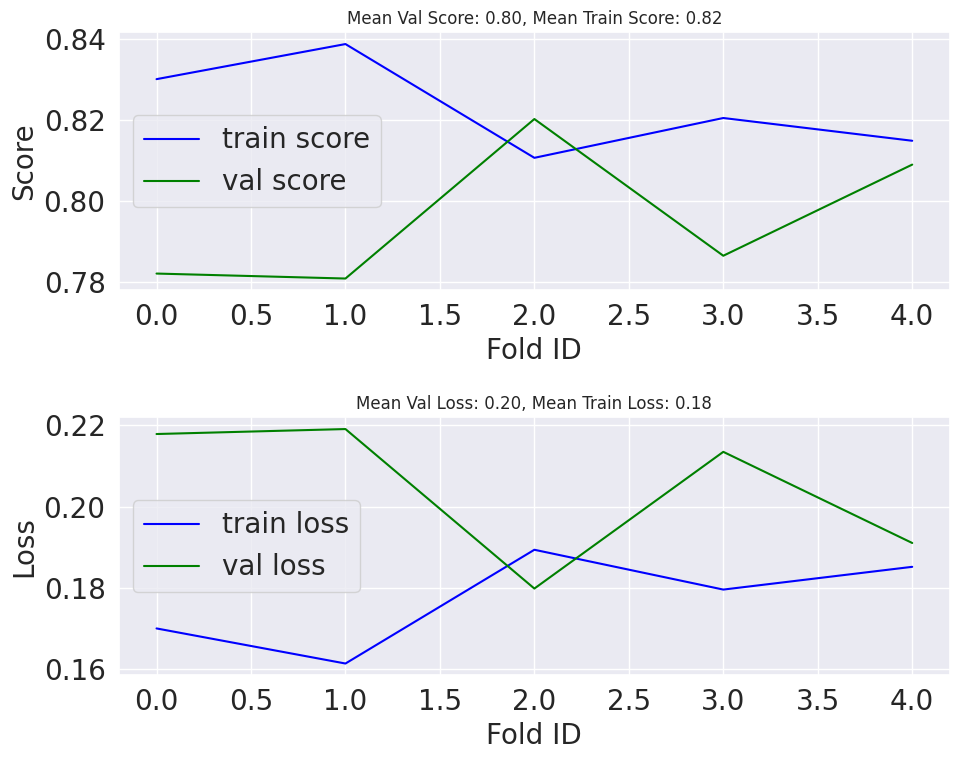

mean cv val score: 0.80
mean cv val loss 0.20
mean cv val score: 0.82
mean cv val loss 0.18


In [324]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X_encoded, t, bag_fold_model, k=5, p=None, show_score_loss_graphs=True, use_pbar=True)
print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
print(f'mean cv val score: {train_score:.2f}\nmean cv val loss {train_loss:.2f}')

Boosting

In [290]:
# get score with bootstrap bagging
bag_boot_model = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=16),
                                   n_estimators=20, random_state=42,
                                   bootstrap=True).fit(X_encoded, t)

print('Accuracy score for classification:')
print('bag_boot_model', bag_boot_model.score(X_encoded, t).mean())

Accuracy score for classification:
bag_boot_model 0.8731762065095399


Computing Models: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


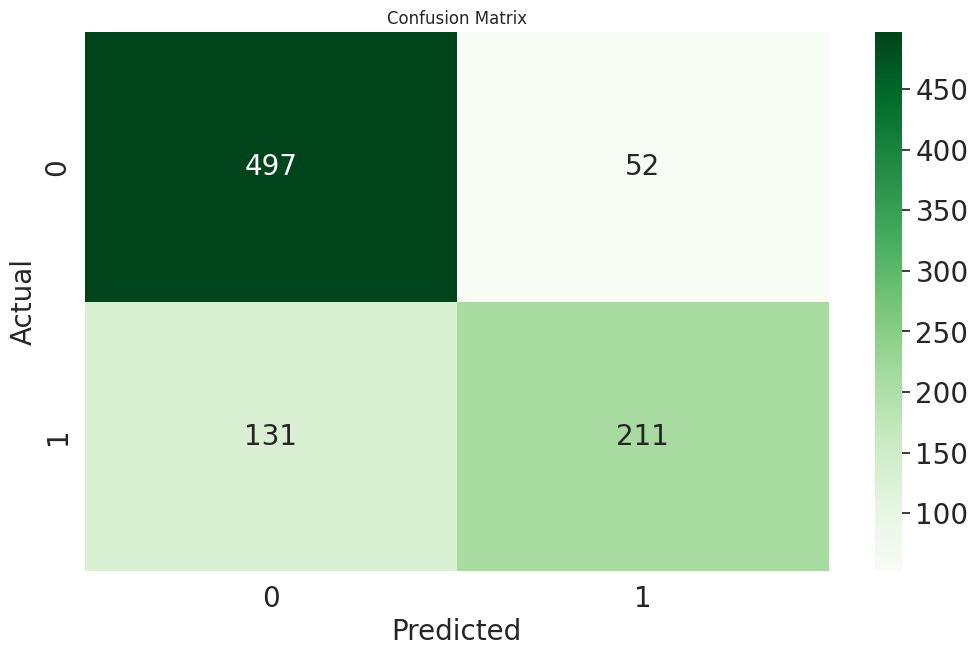

Precision: 0.80
Recall: 0.62
F1-score: 0.70
False Positive Rate (FPR): 0.09
Specificity: 0.91


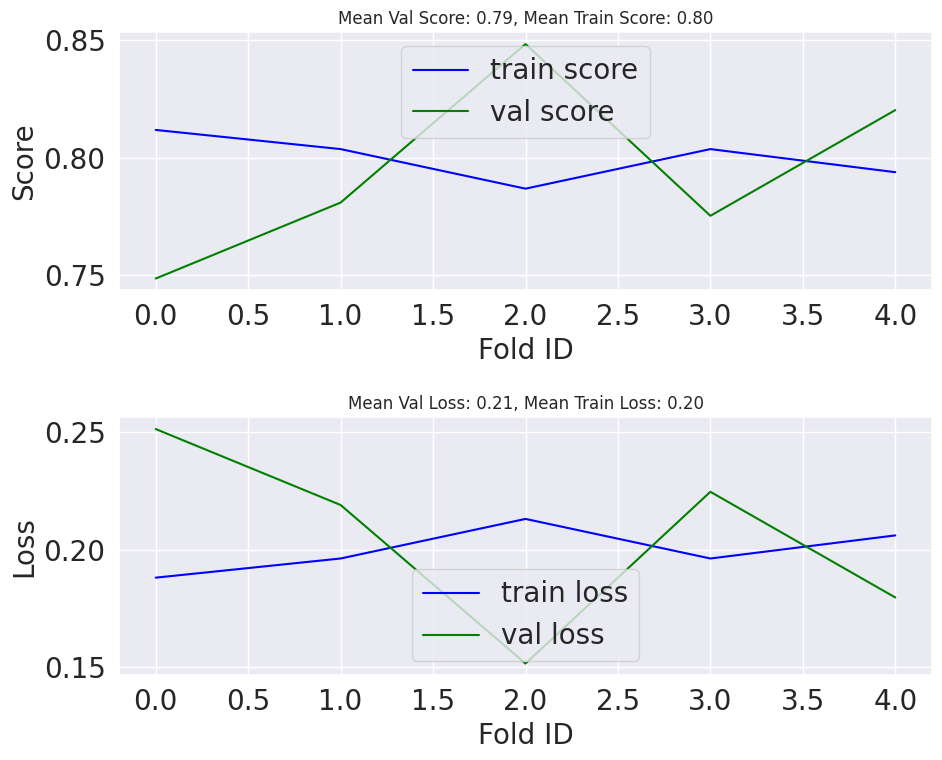

mean cv val score: 0.79
mean cv val loss 0.21
mean cv val score: 0.80
mean cv val loss 0.20


In [291]:
val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X[selected_features_forward], t, bag_boot_model, k=5, p=None, show_score_loss_graphs=True, use_pbar=True)
print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
print(f'mean cv val score: {train_score:.2f}\nmean cv val loss {train_loss:.2f}')

**we can see here that the ensambel of the bagging got us better scores so we will now going to check the bagging ensamble with feature selection**

Accuracy score for classification:
bag_boot_model 0.7991021324354658


Computing Models: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


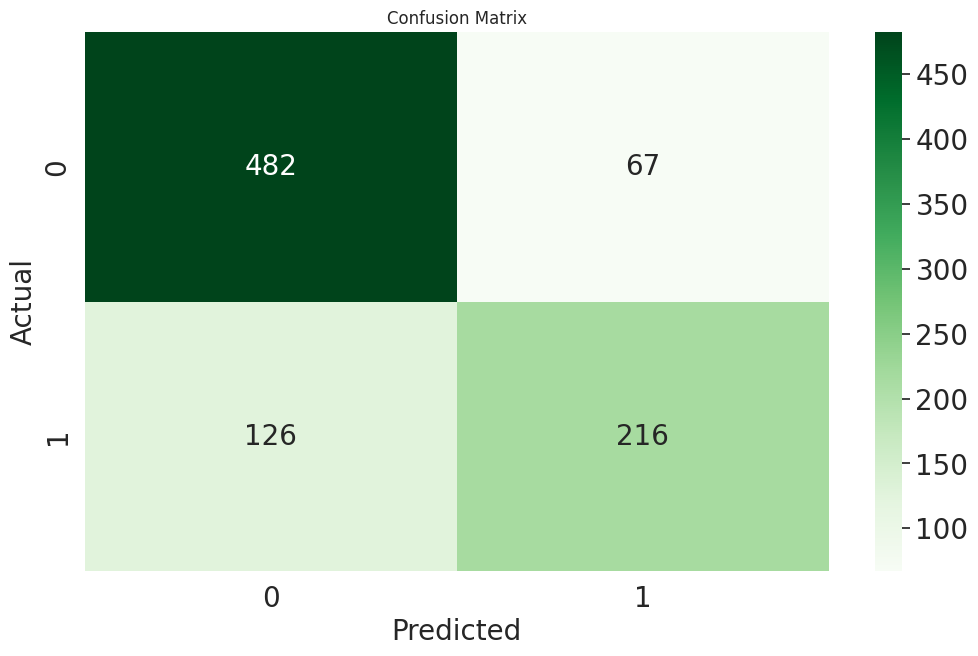

Precision: 0.76
Recall: 0.63
F1-score: 0.69
False Positive Rate (FPR): 0.12
Specificity: 0.88


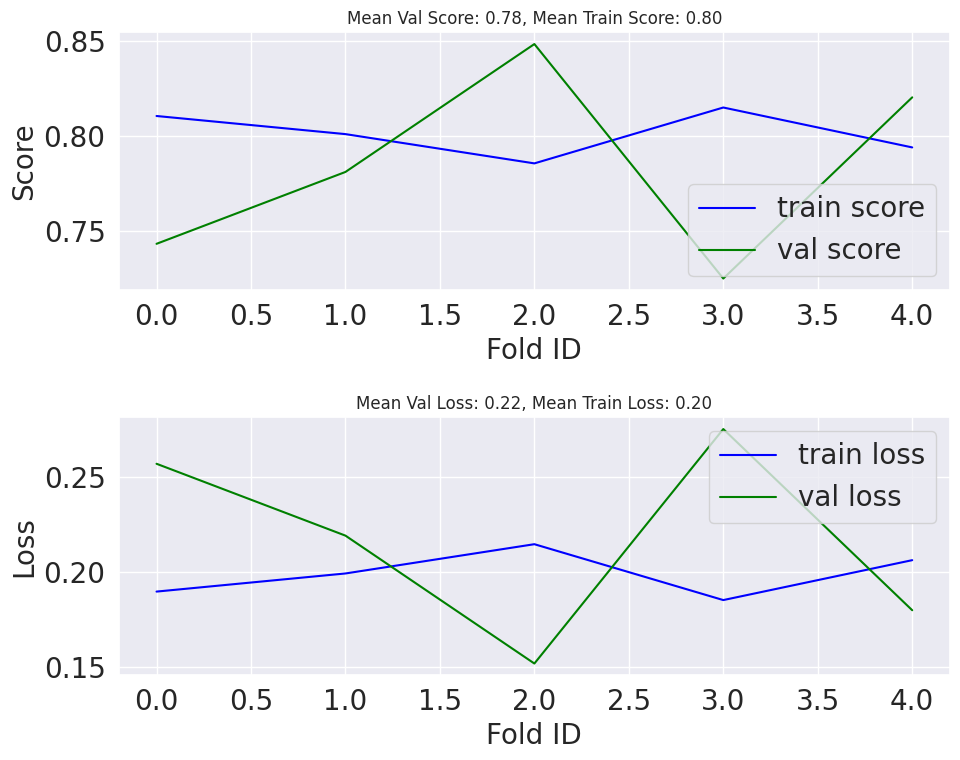

mean cv val score: 0.78
mean cv val loss 0.22
mean cv val score: 0.80
mean cv val loss 0.20


In [328]:
# Get score with bootstrap bagging backward feature selection
bag_fold_model_selector = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=16),
                                   n_estimators=20, random_state=42,
                                   bootstrap=False).fit(x[selected_features_backward], t)

print('Accuracy score for classification:')
print('bag_boot_model', bag_boot_model_selector.score(x[selected_features_backward], t).mean())

val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(x[selected_features_backward], t, bag_boot_model_selector, k=5, p=None, show_score_loss_graphs=True, use_pbar=True)
print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
print(f'mean cv val score: {train_score:.2f}\nmean cv val loss {train_loss:.2f}')

Precision (0.75): This value means that 75% of the predicted positive cases are indeed positive. The model performs moderately well in distinguishing true positives from false positives.

Recall (0.65): This value indicates that the model correctly identifies 65% of the actual positive cases. There's room for the model to improve in detecting all positive instances.

F1-Score (0.69): This score balances precision and recall, suggesting the model maintains a fair compromise between them. However, there's still potential for enhancement.

False Positive Rate (0.14): A false positive rate of 14% shows that the model occasionally predicts positives incorrectly, but it's not excessively frequent.

Specificity (0.86): This value demonstrates that the model correctly identifies 86% of the actual negative cases, indicating a strong performance in recognizing negative instances.

**we are gonna use the bagging without the feature selector!**

# submission


In [285]:
all_cols = np.array(test_df.columns)
all_cols

array(['Status*Pclass', 'Pclass', 'Sex', 'Fare', 'Status'], dtype=object)

In [333]:
scaler = StandardScaler()
test_encoded = pd.DataFrame(scaler.fit_transform(test_df), columns=all_cols)

Submit = bag_fold_model.predict(test_encoded)

output = pd.DataFrame({'PassengerId': test_df_cpy['PassengerId'], 'Survived': Submit})
output.to_csv('submission_ex3_final.csv', index=False)
display(output)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


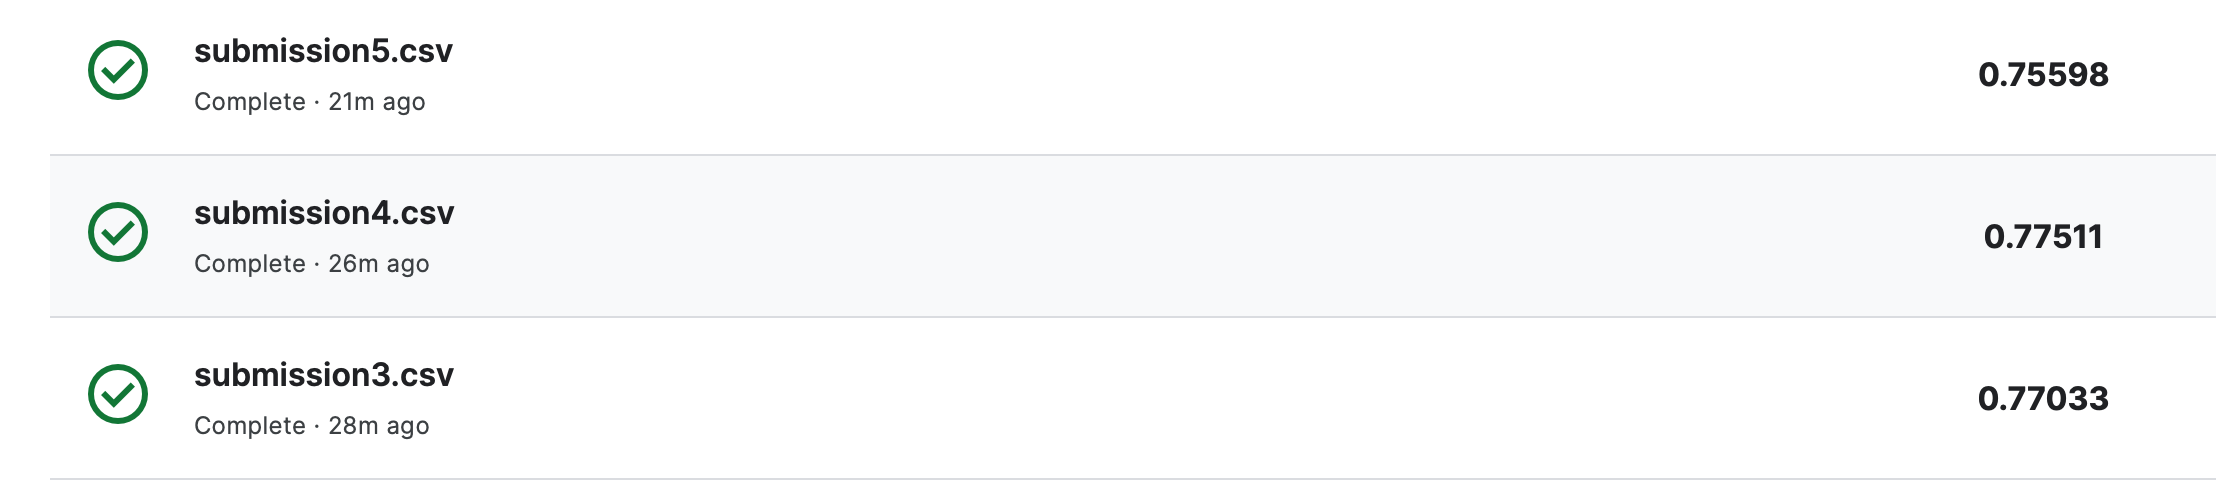

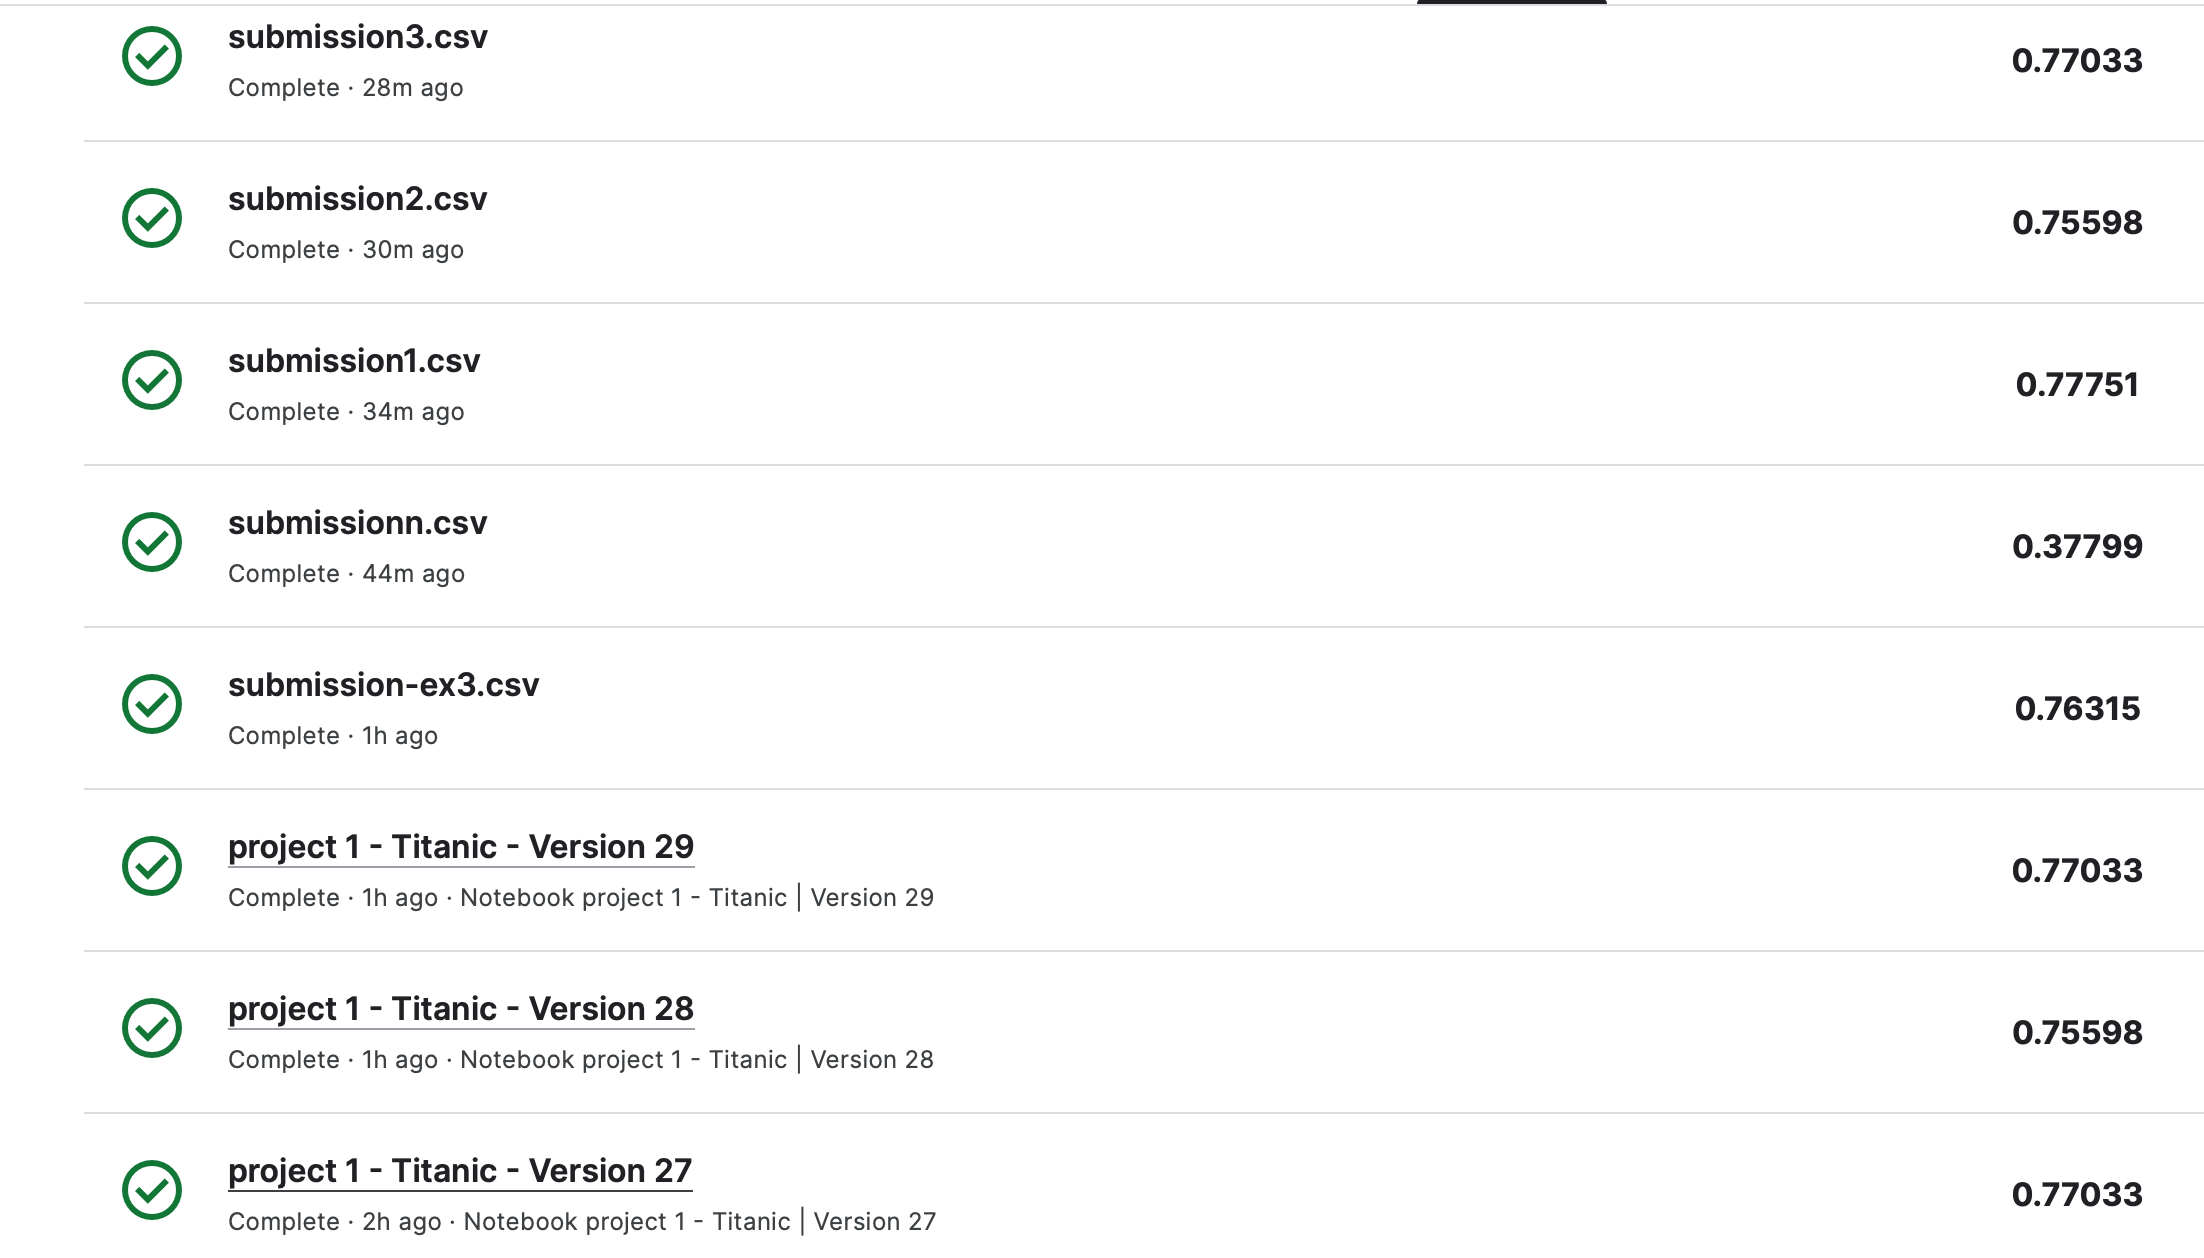

**LeaderBoard**

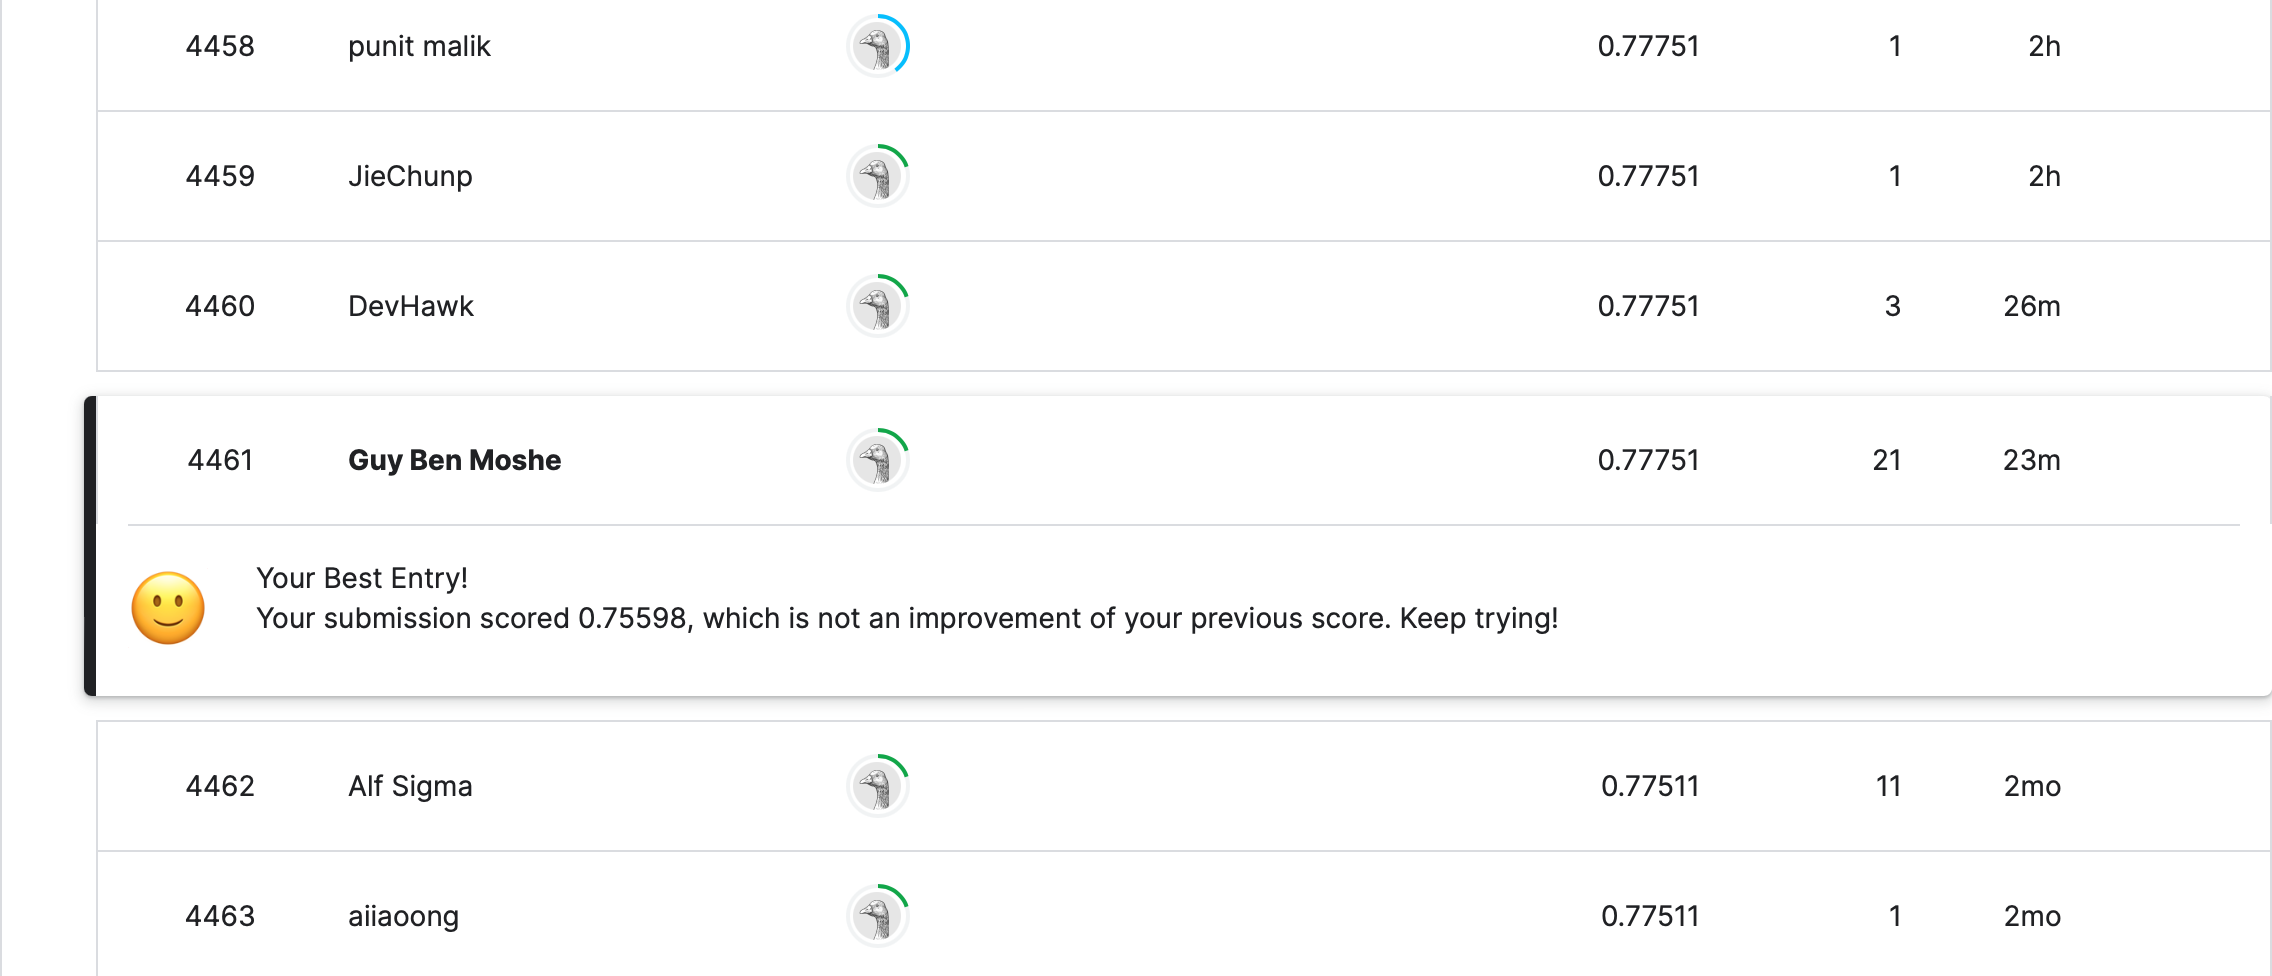

> **Conclusion** 

In our notebook, we began by examining the training dataset, addressing missing values, creating new features with high correlation, and removing redundant columns. We then constructed models using this refined data and evaluated their performance on the test dataset. Throughout the process, we optimized parameters at every stage to improve the model scores.